In [20]:
#pip install cvxpy[GLPK,SCIP]

In [21]:
from cvxpy import *

print(installed_solvers())

['CBC', 'CLARABEL', 'CPLEX', 'CVXOPT', 'ECOS', 'ECOS_BB', 'GLOP', 'GLPK', 'GLPK_MI', 'GUROBI', 'MOSEK', 'OSQP', 'PDLP', 'SCIP', 'SCIPY', 'SCS', 'XPRESS']


# Optimal path planning in the workspace for articulated robots using mixed integer programming

This is an attempt to reproduce the following papers:

Main paper:
- [Ding, H., Zhou, M., & Stursberg, O. (2009). Optimal path planning in the workspace for articulated robots using mixed integer programming. 2009 IEEE/RSJ International Conference on Intelligent Robots and Systems, 5770–5775](https://doi.org/10.1109/IROS.2009.5354313)

Additional references:

- [Ding, H., Reissig, G., Gross, D., & Stursberg, O. (2011). Mixed-integer programming for optimal path planning of robotic manipulators. 2011 IEEE International Conference on Automation Science and Engineering, 133–138]( https://doi.org/10.1109/CASE.2011.6042462)

## Plotting stuffs

In [22]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
from matplotlib import rc
import numpy as np

plt.rcParams.update({'font.size':7});
rc('animation', html='jshtml');

def show_animation(x1, x2, L1, L2, x1p=None, x2p=None, COM1=None, COM2=None, C=None, CM=None, interval=None):
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(autoscale_on=False, xlim=(-(L1+L2), L1+L2), ylim=(-(L1+L2), L1+L2))

    for j in range(len(x1)):
        ax.plot([0, x1[j,0]], [0, x1[j,1]], 'lightgray')
        ax.plot([x1[j,0], x2[j,0]], [x1[j,1], x2[j,1]], 'lightgray')

    h3, = ax.plot(x1[:,0], x1[:,1], color='r', marker='.', alpha=0.2)
    h4, = ax.plot(x2[:,0], x2[:,1], color='b', marker='.', alpha=0.2)
    h2, = ax.plot([0, 0], [0, 0], color='k', marker='s', linewidth=3, markerfacecolor='b', markeredgecolor='k')
    h1, = ax.plot([0, 0], [0, 0], color='k', marker='s', linewidth=3, markerfacecolor='r', markeredgecolor='k')

    if x1p is not None:
        h5, = ax.plot([0, 0], [0, 0], '.g')
        
    if x2p is not None:
        h6, = ax.plot([0, 0], [0, 0], '.g')

    if COM1 is not None:
        h7, = ax.plot([0, 0], [0, 0], '*r')

    if COM2 is not None:
        h8, = ax.plot([0, 0], [0, 0], '*b')
        
    if C is not None:
        RECTS = []
        for k in range(len(C)):
            RECTS.append(patches.Rectangle((C[k,0], C[k,2]),
                                        np.abs(C[k,0]-C[k,1]),
                                        np.abs(C[k,2]-C[k,3]),
                                        ec='k', fc='lightgray',
                                        linestyle='--')
        )

        for k in range(len(RECTS)):
            ax.add_patch(RECTS[k])
        
    if CM is not None:
        h9 = patches.Rectangle((0., 0.),
                                0.1,
                                0.1,
                                ec='k', fc='lightgray',
                                linestyle='--')
        ax.add_patch(h9)

    ax.set_aspect('equal');
    ax.grid();
    ax.axis('equal');

    def animate(k):
        h = []
        h1.set_data([0, x1[k,0]], [0, x1[k,1]])
        h.append(h1)
        h2.set_data([x1[k,0], x2[k,0]], [x1[k,1], x2[k,1]])
        h.append(h2)

        if x1p is not None:
            h5.set_data(x1p[k, 0::2], x1p[k, 1::2])
            h.append(h5)

        if x2p is not None:
            h6.set_data(x2p[k,0::2], x2p[k,1::2])
            h.append(h6)

        if COM1 is not None:
            h7.set_data(COM1[k,0::2], COM1[k,1::2])
            h.append(h7)

        if COM2 is not None:
            h8.set_data(COM2[k,0::2], COM2[k,1::2])
            h.append(h8)

        if CM is not None:
            h9.set_xy((CM[k,0], CM[k,2]))
            h9.set_width(np.abs(CM[k,0]-CM[k,1]))
            h9.set_height(np.abs(CM[k,2]-CM[k,3]))
            h.append(h9)

        return h

    if interval is None:
        interval = 100

    ani = animation.FuncAnimation(fig, animate, len(x1), interval=interval, blit=True)

    return ani;

In [23]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 7})

def plot(t, x1, x2, v1max=None, v2max=None, v1init=0, v2init=0):
    fig = plt.figure(figsize=(5, 3));
    ax = fig.subplots(2, 1, height_ratios=[1,1]);

    dt = t[1]-t[0]
    v1 = np.ones([len(t),2])*v1init
    v2 = np.ones([len(t),2])*v2init
    v1[1:,:] = np.diff(x1,axis=0)/dt
    v2[1:,:] = np.diff(x2,axis=0)/dt

    ax[0].plot(t, np.sqrt(v1[:,0]**2+v1[:,1]**2), '.-r')
    ax[1].plot(t, np.sqrt(v2[:,0]**2+v2[:,1]**2), '.-b')

    if v1max is not None:
        for k in range(len(v1max)):
            ax[0].plot([t[0],t[-1]], [v1max[k], v1max[k]],'--k')

    if v2max is not None:
        for k in range(len(v1max)):
            ax[1].plot([t[0],t[-1]], [v2max[k], v2max[k]],'--k')

    ax[0].set_xlabel('$Time (s)$');
    ax[0].set_ylabel('$|v_1|$');

    ax[1].set_xlabel('$Time (s)$');
    ax[1].set_ylabel('$|v_2|$');

    plt.tight_layout()

----
## Inverse kinematics of a two-link planar SCARA robot (RR)

Before reproducing the whole paper, let us first start with a simple implementation of a SCARA inverse kinematic function by using a mixed-integer programming technique, which can be found in **Section II.B** of the paper (*Kinematic Constraints*).

Descriptions:

$x_{1}$  is the end-point position of link 1.

$x_{2}$  is the end-point position of link 2.

$x_{1}, x_{2} \in \mathbb{R}^2 $

All figures in the paper show a SCARA arm in an elbow-up configuration. However, the paper does not mention anything about the constraints for the elbow-up/down configuration. We will be creative and program the constraints ourselves.

To enable certain configuration (elbow-up/down), we first define a line that spans from origin to the target point.
$$cx|_{x=(0,0)}=0 \, \text{and} \, cx|_{x=x_t}=0\\ c,x \in \mathrm{R}^2$$

After that, we check if $x_1$ is located below or above this line.


In [24]:
import numpy as np
from cvxpy import *

def ikine(XT, L1, L2, type=0, solver='SCIP'):
    N = len(XT)

    x1 = Variable(2) # end point of link-1
    x2 = Variable(2) # end point of link-2
    xt = Parameter(2)

    constraints = [x2 == xt]

    R = 20

    # Polytopic circle
    M = 32
    b1 = Variable(M, boolean=True)
    b2 = Variable(M, boolean=True)
    for m in range(0, M):
        # Circumscribed, eq. (6)
        constraints += [((x2[0]-x1[0])*np.sin(2*np.pi*(m+1)/M) + (x2[1]-x1[1])*np.cos(2*np.pi*(m+1)/M)) <= L1]
        constraints += [(x1[0]*np.sin(2*np.pi*(m+1)/M) + x1[1]*np.cos(2*np.pi*(m+1)/M)) <= L2]
        # Inscribed, eq. (7)
        constraints += [((x2[0]-x1[0])*np.sin(2*np.pi*(m+1)/M) + (x2[1]-x1[1])*np.cos(2*np.pi*(m+1)/M)) >= L1*np.cos(np.pi/M)-b1[m]*R]
        constraints += [(x1[0]*np.sin(2*np.pi*(m+1)/M) + x1[1]*np.cos(2*np.pi*(m+1)/M)) >= L2*np.cos(np.pi/M)-b2[m]*R]

    constraints += [sum(b1) <= M-1, sum(b2) <= M-1] # eq. (8)

    if type == 0:
        constraints += [xt[1]*x1[0] - xt[0]*x1[1] >= 0] # Elbow-up or elbow down?
    elif type == 1:
        constraints += [xt[1]*x1[0] - xt[0]*x1[1] <= 0] # Elbow-up or elbow down?

    X1 = np.zeros((N,2), dtype=np.float32)
    X2 = np.zeros((N,2), dtype=np.float32)
    for k in range(N):
        xt.value = XT[k,:]
        prob = Problem(Minimize(0.0), constraints)

        res = prob.solve(solver=solver, verbose=False)

        X1[k,:] = x1.value
        X2[k,:] = x2.value

    return X1, X2


Let us test our implementation.
In the paper, the length of the SCARA arms are as follows:
```
L1 = 0.3
L2 = 0.3
```
We will make as if the SCARA robot moves from $[-0.6,0]$ to $[0.6,0]$.

In [25]:
L1 = 0.3
L2 = 0.3

xt = np.linspace(-0.6, 0.6, 100)
yt = np.ones(len(xt)) * 0.
XT = np.vstack((xt,yt)).transpose()

First possible arm configuration.

In [26]:
%matplotlib notebook

X1, X2 = ikine(XT, L1, L2, type=0, solver='SCIP')
show_animation(X1, X2, L1, L2)

<IPython.core.display.Javascript object>

Second possible arm configuration.

In [27]:
%matplotlib notebook

X1, X2 = ikine(XT, L1, L2, type=1, solver='SCIP')
show_animation(X1, X2, L1, L2)

<IPython.core.display.Javascript object>

Next, to assure ourselves that the results are correct, we need to check the length of each link at every time iteration. The calculated lengths must be as close as possible to the actual lengths.

In [28]:
error1 = np.abs(L1 - np.linalg.norm(np.array(X1), axis=1))
print(np.mean(error1))

0.000994854


In [29]:
error2 = np.abs(L2 - np.linalg.norm(np.array(X2)-np.array(X1), axis=1))
print(np.mean(error2))

0.00058695464


If necessary, in the final step, we compute $\theta_1$ and $\theta_2$ by using some trigonometric rules. However, we will not do it.

---

## Section III-A: Implementation

The example problems in the paper are mainly to move the robot's joints from $[0, 0]^T$ rad to $[\pi/2, -\pi/4]^T$ rad. The robot is always fixed at $[0, 0]$ m. The user can limit the velocities of every end point of every link. These limits are the magnitude of the velocity vectors in cartesian space ($\sqrt{v_x^2+v_y^2}$). In the paper, it is named as maximum absolute velocities. Simply put, $V_{\text{max}}=[v_{0,\text{max}}, v_{2,\text{max}}, v_{2,\text{max}}]$. In this case, $v_{0,\text{max}}$ is always zero since the robot's base is fixed.

Let us set up the following constraints:

**Initial positions**

$ x_{1,0}=\big[ 0.3, \, 0.0\big]$

$ x_{2,0}=\big[ 0.6, \, 0\big]$

**Target positions**

$x_{1,N}=\big[ 0.0, \, 0.3\big]\\$

$x_{2,N}=\big[ 0.3\cdot\sin(\pi/4), \, 0.3+0.3\cdot\cos(\pi/4)]$

**Link-end velocities**

$V_{\text{max}} = \big[ 0, \, 0.7, \, 1\big]^{T}$

**Time horizon**

$\Delta t = 0.1$

$N = 25$


**Demo task**

Find the *minimum-time trajectory* from initial position to target position.

Link-end velocities and time horizon are not mentioned yet in this section of the paper. Thus, we choose some arbitrary values.

**Problem formulation:**

$$
\min_{x_1, x_2,c} N  \\
\text{subject to:} \\
\forall k \in [0 \dots N]\\
\text{Intial and terminal constraints:} \\
x_1(0) = x_{1,0}, x_1(N) = x_{1,N} \\
x_2(0) = x_{2,0}, x_2(N) = x_{2,N} \\
\text{Kinematic constraints:} \\
\lVert x_1(k)\rVert_2  = L_1 \\
\lVert x_2(k)-x_1(k) \rVert_2 = L_2 \\
\lVert x_2(k+1)-x_2(k) \rVert_2 \leq v_{2,\text{max}} \\
\lVert x_1(k+1)-x_1(k) \rVert_2 \leq v_{1,\text{max}} \\
\text{Minumum-time constraints:} \\
-R(1-c(k)) \geq x_{1,k}-x_{1,N} \leq R(1-c(k)) \\
-R(1-c(k)) \geq x_{2,k}-x_{2,N} \leq R(1-c(k))\\
c(k) \in \{0,1\} \\
\sum_{k=0}^{N} c(k) = 1 \\
R \, \text{is a sufficiently large positive number}
$$



Here, we do need need to worry about the elbow-up/down configuration. The terminal states are available for all joints.

In [30]:
import numpy as np
from cvxpy import *

L1 = 0.3 # meters
L2 = 0.3 # meters

dt = 0.1 # seconds
N = 25   # steps

x10 = np.array([ 0.3, 0.0])
x20 = np.array([ 0.6, 0.0])
x1f = np.array([0.0, 0.3])
x2f = np.array([0.3*np.sin(np.pi/4), 0.3+0.3*np.cos(np.pi/4)])
Vmax = np.array([0.0, 0.4, 0.6])
Vmin = np.array([0.0, 0.3, 0.5])

x1 = Variable((2,N+1)) # end point of link-1
x2 = Variable((2,N+1)) # end point of link-2

constraints  = [x1[:,0] == x10] # initial position
constraints += [x2[:,0] == x20] # initial position
constraints += [x1[:,N] == x1f] # terminal position
constraints += [x2[:,N] == x2f] # terminal position

# The big integer
R = 20

# Polytopic circle
M   = 32 # increase this number to increase the accuracy of the results
b1  = Variable((M,N+1), boolean=True)
b2  = Variable((M,N+1), boolean=True)

for k in range (1,N):
    for m in range(0, M):
        # Polygon circumscribes the circle, eq. (6)
        constraints += [((x2[0,k]-x1[0,k])*np.sin(2*np.pi*(m+1)/M) + (x2[1,k]-x1[1,k])*np.cos(2*np.pi*(m+1)/M)) <= L1]
        constraints += [((x1[0,k])*np.sin(2*np.pi*(m+1)/M) + (x1[1,k])*np.cos(2*np.pi*(m+1)/M)) <= L2]
        # Inscribed, eq. (7)
        constraints += [((x2[0,k]-x1[0,k])*np.sin(2*np.pi*(m+1)/M) + (x2[1,k]-x1[1,k])*np.cos(2*np.pi*(m+1)/M)) >= L1*np.cos(np.pi/M)-b1[m,k]*R]
        constraints += [((x1[0,k])*np.sin(2*np.pi*(m+1)/M) + (x1[1,k])*np.cos(2*np.pi*(m+1)/M)) >= L2*np.cos(np.pi/M)-b2[m,k]*R]

    constraints += [sum(b1[:,k]) <= M-1, sum(b2[:,k]) <= M-1] # eq. (8)

# Minimum-time constraints    
c = Variable(N+1, boolean=True)
Tf = Variable(1)
tf = 0

for k in range(0,N+1):    
    constraints += [(x1[0,k]-x1f[0]) <=  R*(1-c[k]),
                    (x1[0,k]-x1f[0]) >= -R*(1-c[k]),
                    (x1[1,k]-x1f[1]) <=  R*(1-c[k]),
                    (x1[1,k]-x1f[1]) >= -R*(1-c[k]),
                    (x2[0,k]-x2f[0]) <=  R*(1-c[k]),
                    (x2[0,k]-x2f[0]) >= -R*(1-c[k]),
                    (x2[1,k]-x2f[1]) <=  R*(1-c[k]),
                    (x2[1,k]-x2f[1]) >= -R*(1-c[k])]

    tf += k*dt*c[k]
constraints += [sum(c) == 1]
constraints += [Tf >= tf]


# Using norm2 to constraint the velocity
M = 32
for k in range(N):
    for m in range(1,M+1):
        constraints += [((x1[0,k+1]-x1[0,k])*np.sin(2*np.pi*m/M) + (x1[1,k+1]-x1[1,k])*np.cos(2*np.pi*m/M)) <= Vmax[1]*dt]
        constraints += [((x2[0,k+1]-x2[0,k])*np.sin(2*np.pi*m/M) + (x2[1,k+1]-x2[1,k])*np.cos(2*np.pi*m/M)) <= Vmax[2]*dt]

J = Tf
prob = Problem(Minimize(J), constraints)

res = prob.solve(verbose=False, solver=SCIP)
#res = prob.solve(verbose=True, solver=MOSEK, mosek_params = {'MSK_IPAR_INTPNT_SOLVE_FORM':'MSK_SOLVE_DUAL' })
#res = prob.solve(solver=CPLEX, cplex_params={'threads':72}, verbose=True)

print("J =", J.value)                                                                                                                                                                                                                                                                                           
print("Tf =", Tf.value)

# Trim the results
X1 = np.array(x1.value).transpose()[0:np.int32(Tf.value[0]/dt)+1,:]
X2 = np.array(x2.value).transpose()[0:np.int32(Tf.value[0]/dt)+1,:]
N = len(X1)

J = [1.2]
Tf = [1.2]


In [31]:
%matplotlib notebook

show_animation(np.array(X1), np.array(X2), L1, L2)

<IPython.core.display.Javascript object>

Now, let's check if the generated trajectory respects the given velocity constraints.

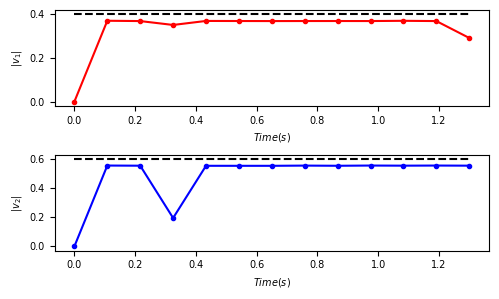

In [32]:
%matplotlib inline
t = np.linspace(0, N*dt, N)
plot(t, X1, X2, v1max=[Vmax[1]], v2max=[Vmax[2]])

Everything seems perfect so far!

----
## Section III-B: Minimization of Average Kinetic Energy with Varying Velocity Limits and Static Obstacles

$\Delta t = 0.1 \text{s}$

There are two half spaces, divided by a line $c \cdot x = 0$, where $c=[1, -1]$.

$V_{\text{max}} = [0, 0.7, 1.0] \text{m/s}$ in one half space ($c \cdot x <0$) and $V_{\text{max}} = [0, 1.0, 1.5] \text{m/s}$ in another half space ($c \cdot x \geq 0$).

The planning horizon is 10 steps.

There are two rectangle obstacles.

The masses of each link is $1$ kg and its center of mass is located at the center.

**Problem formulation:**

$$
\min_{x_1, x_2,d} J  \\
\text{subject to:} \\
\forall k \in [0 \dots N]\\
\text{Intial and terminal constraints:} \\
x_1(0) = x_{1,0}, x_1(N) = x_{1,N} \\
x_2(0) = x_{2,0}, x_2(N) = x_{2,N}
$$

$$
\text{Kinematic constraints:} \\
\lVert x_1(k)\rVert  = L_1 \\
\lVert x_2(k)-x_1(k) \rVert = L_2 \\
\lVert x_2(k+1)-x_2(k) \rVert \leq v_{2,\text{max}} \\
\lVert x_1(k+1)-x_1(k) \rVert \leq v_{1,\text{max}} 
$$

$$
\text{Minimum kinetic energy constraints:} \\
J = \frac{1}{2N} \sum \Bigg[ m_1 \, \bigg\Vert\frac{x_{\text{COM1}}(k+1)-x_{\text{COM1}}(k)}{\Delta t}\bigg\Vert^2 + m_2 \, \bigg\Vert\frac{x_{\text{COM2}}(k+1)-x_{\text{COM2}}(k)}{\Delta t}\bigg\Vert^2 \Bigg]\\
x_{\text{COM1}} = 0.5 \, x_1, \, x_{\text{COM1}} \in \mathrm{R}^2\\\\
x_{\text{COM2}} = 0.5(x_2-x_1)+x1, \, x_{\text{COM2}} \in \mathrm{R}^2\\
$$

$$
\text{Collision avoidance contraints:} \\
\forall p = \{0 \dots P-1\} \\
x_{p} = \frac{p}{P-1}(x_2-x_1)+x1, x_p \in \mathrm{R}^2\\
\forall l = \{1 \dots L\}, L=\text{total number of the rectangle obstacles} \\
x_{p_x} \leq x_{l,\text{left}}\,R\,d_{p,1}(k) \\
-x_{p_x} \leq -x_{l,\text{right}}\,R\,d_{p,2}(k) \\
x_{p_y} \leq y_{l,\text{top}}\,R\,d_{p,3}(k)\\
-x_{p_y} \leq -y_{l,\text{bottom}}\,R\,d_{p,4}(k)\\
\sum d_{p,1}(k)+d_{p,2}(k)+d_{p,3}(k)+d_{p,4}(k) \leq 3 \\
d_{p,1}(k),d_{p,2}(k), d_{p,3}(k), d_{p,4}(k) \in \{0, 1 \} \\
$$
$$
R \, \text{is a sufficiently large positive number}
$$



In [33]:
import numpy as np
from cvxpy import *

L1 = 0.3 # meters
L2 = 0.3 # meters

dt = 0.1 # seconds
N = 9    # 10 steps, from 0 to 9

x10 = np.array([ 0.3, 0.0])
x20 = np.array([ 0.6, 0.0])
x1f = np.array([0.0, 0.3])
x2f = np.array([0.3*np.sin(np.pi/4), 0.3+0.3*np.cos(np.pi/4)])

Vmax1 = np.array([0.0, 1.0, 1.5])
Vmax2 = np.array([0.0, 0.7, 1.0])

x1 = Variable((2,N+1)) # end point of link-1
x2 = Variable((2,N+1)) # end point of link-2

constraints  = [x1[:,0] == x10] # initial position
constraints += [x2[:,0] == x20] # initial position
constraints += [x1[:,N] == x1f] # terminal position
constraints += [x2[:,N] == x2f] # terminal position

# The big integer
R = 20

# Kinematic constraints
M   = 20 # increase this number to increase the accuracy of the results
b1  = Variable((M,N), boolean=True)
b2  = Variable((M,N), boolean=True)

for k in range (1,N):
    for m in range(0, M):
        # Circumscribed, eq. (6)
        constraints += [((x2[0,k]-x1[0,k])*np.sin(2*np.pi*(m+1)/M) + (x2[1,k]-x1[1,k])*np.cos(2*np.pi*(m+1)/M)) <= L1]
        constraints += [((x1[0,k])*np.sin(2*np.pi*(m+1)/M) + (x1[1,k])*np.cos(2*np.pi*(m+1)/M)) <= L2]
        # Inscribed, eq. (7)
        constraints += [((x2[0,k]-x1[0,k])*np.sin(2*np.pi*(m+1)/M) + (x2[1,k]-x1[1,k])*np.cos(2*np.pi*(m+1)/M)) >= L1*np.cos(np.pi/M)-b1[m,k]*R]
        constraints += [((x1[0,k])*np.sin(2*np.pi*(m+1)/M) + (x1[1,k])*np.cos(2*np.pi*(m+1)/M)) >= L2*np.cos(np.pi/M)-b2[m,k]*R]

    constraints += [sum(b1[:,k]) <= M-1, sum(b2[:,k]) <= M-1] # eq. (8)


# Using norm2 to constraint the velocity
M = 16
c11  = Variable((N), boolean=True)
c12  = Variable((N), boolean=True)
c21  = Variable((N), boolean=True)
c22  = Variable((N), boolean=True)
c = np.array([1.0,-1.0])

for k in range(0,N):
    constraints += [c@x1[:,k] <= c11[k]*R, c@x1[:,k] >= -c12[k]*R, c11[k]+c12[k]==1]
    constraints += [c@x2[:,k] <= c21[k]*R, c@x2[:,k] >= -c22[k]*R, c21[k]+c22[k]==1]

    for m in range(0,M):
        constraints += [((x1[0,k+1]-x1[0,k])*np.sin(2*np.pi*(m+1)/M) + (x1[1,k+1]-x1[1,k])*np.cos(2*np.pi*(m+1)/M)) <= Vmax1[1]*dt+c11[k]*R]
        constraints += [((x2[0,k+1]-x2[0,k])*np.sin(2*np.pi*(m+1)/M) + (x2[1,k+1]-x2[1,k])*np.cos(2*np.pi*(m+1)/M)) <= Vmax1[2]*dt+c21[k]*R]

        constraints += [((x1[0,k+1]-x1[0,k])*np.sin(2*np.pi*(m+1)/M) + (x1[1,k+1]-x1[1,k])*np.cos(2*np.pi*(m+1)/M)) <= Vmax2[1]*dt+c12[k]*R]
        constraints += [((x2[0,k+1]-x2[0,k])*np.sin(2*np.pi*(m+1)/M) + (x2[1,k+1]-x2[1,k])*np.cos(2*np.pi*(m+1)/M)) <= Vmax2[2]*dt+c22[k]*R]

# Collision/obstacles avoidance
# Particles in the links for collision avoidance
P = 12 # number of the particles for each link
#x1p = Variable((2*P,N+1)) # Particles in the first link
x2p = Variable((2*P,N+1))  # Particles in the second link
x1c = Variable((2,N+1)) # COM first link
x2c = Variable((2,N+1)) # COM second link

for k in range(0,N+1):
    for p in range(P):
        #constraints += [x1p[0+2*p:2+2*p, k]==x1[:, k]*p/(P-1)+np.zeros(2)]
        constraints += [x2p[0+2*p:2+2*p, k]==(x2[:, k]-x1[:, k])*p/(P-1)+x1[:, k]]

    constraints += [x1c[:, k]==(x1[:, k])*0.5] # COM1
    constraints += [x2c[:, k]==(x2[:, k]-x1[:, k])*0.5+x1[:, k]] # COM2

C = np.array([[0.4, 0.5, 0.1, 0.2],
              [0.35, 0.45, 0.3, 0.4]])
L = len(C) # Number of the rectangular obstacles

d1 = Variable((L*P, N+1), boolean=True)
d2 = Variable((L*P, N+1), boolean=True)
d3 = Variable((L*P, N+1), boolean=True)
d4 = Variable((L*P, N+1), boolean=True)

for k in range(0,N+1):
    for l in range(L):  # eq. (8)
        for p in range(P):
            constraints += [x2p[0+2*p, k]  <=  C[l, 0] + R*d1[l+p*L,k],
                            -x2p[0+2*p, k] <= -C[l, 1] + R*d2[l+p*L,k],
                            x2p[1+2*p, k]  <=  C[l, 2] + R*d3[l+p*L,k],
                            -x2p[1+2*p, k] <= -C[l, 3] + R*d4[l+p*L,k]]
            constraints += [d1[l+p*L,k] + d2[l+p*L,k] + d3[l+p*L,k] + d4[l+p*L,k] <= 3]

# Minimum kinetic energy constraint
norm2v1 = Variable(N+1)
norm2v2 = Variable(N+1)
M = 8
for k in range(0,N):
    for m in range(0,M):
        constraints += [((x1c[0,k+1]-x1c[0,k])*np.sin(2*np.pi*(m+1)/M) + (x1c[1,k+1]-x1c[1,k])*np.cos(2*np.pi*(m+1)/M)) <= norm2v1[k]*dt]
        constraints += [((x2c[0,k+1]-x2c[0,k])*np.sin(2*np.pi*(m+1)/M) + (x2c[1,k+1]-x2c[1,k])*np.cos(2*np.pi*(m+1)/M)) <= norm2v2[k]*dt]

J = 1/N*(0.5*sum_squares(norm2v2) + 0.5*sum_squares(norm2v1))
prob = Problem(Minimize(J), constraints)

res = prob.solve(verbose=False, solver=SCIP)
#res = prob.solve(verbose=True, solver=MOSEK, mosek_params = {'MSK_IPAR_INTPNT_SOLVE_FORM':'MSK_SOLVE_DUAL' })
#res = prob.solve(solver=CPLEX, cplex_params={'threads':72}, verbose=True)
#res = prob.solve(solver=GUROBI, verbose=True)

# Trim the results
X1  = np.array(x1.value).transpose()
X2  = np.array(x2.value).transpose()
#X1P = x1p.value.transpose()
X2P = x2p.value.transpose()
COM1 = x1c.value.transpose()
COM2 = x2c.value.transpose()


N = len(X1)

In [34]:
%matplotlib notebook

ani = show_animation(np.array(X1), np.array(X2), L1, L2, x2p=X2P, COM1=COM1, COM2=COM2, C=C, interval=200)
ani

<IPython.core.display.Javascript object>

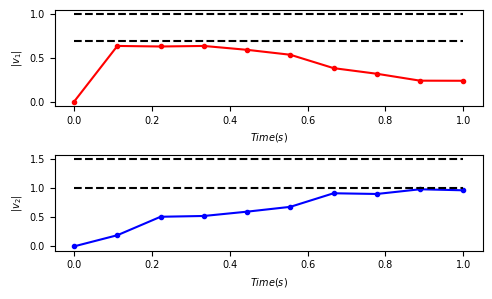

In [35]:
%matplotlib inline
t = np.linspace(0, N*dt, N)
plot(t, X1, X2, v1max=[Vmax1[1], Vmax2[1]], v2max=[Vmax1[2], Vmax2[2]])

In [36]:
ani.save("fig1.gif")

----
## Section III-C: Minimization of the Transition Time and Static Obstacles

$\Delta t = 0.1 \text{s}$

$V_{\text{max}} = [0, 0.4, 0.6] \, \text{m/s}$

The planning horizon is 25 steps.

There are two obstacles and NO variation of the velocity limits over different regions.

**Problem formulation:**

$$
\min_{x_1, x_2,c,d} N  \\
\text{subject to:} \\
\forall k \in [0 \dots N]\\
\text{Intial constraints:} \\
x_1(0) = x_{1,0} \\
x_2(0) = x_{2,0}
$$

$$
\text{Kinematic constraints:} \\
\lVert x_1(k)\rVert_2  = L_1 \\
\lVert x_2(k)-x_1(k) \rVert_2 = L_2 \\
\lVert x_2(k+1)-x_2(k) \rVert_2 \leq v_{2,\text{max}} \\
\lVert x_1(k+1)-x_1(k) \rVert_2 \leq v_{1,\text{max}} 
$$

$$
\text{Minimum-time constraints:} \\
-R(1-c(k)) \geq x_{1,k}-x_{1,N} \leq R(1-c(k)) \\
-R(1-c(k)) \geq x_{2,k}-x_{2,N} \leq R(1-c(k))\\
c(k) \in \{0,1\} \\
\sum_{k=0}^{N} c(k) = 1 
$$

$$
\text{Collision avoidance contraints:} \\
\forall p = \{0 \dots P-1\} \\
x_{p} = \frac{p}{P-1}(x_2-x_1)+x1, x_p \in \mathrm{R}^2\\
\forall l = \{1 \dots L\}, L=\text{total number of the rectangle obstacles} \\
x_{p_x} \leq x_{l,\text{left}}\,R\,d_{p,1}(k) \\
-x_{p_x} \leq -x_{l,\text{right}}\,R\,d_{p,2}(k) \\
x_{p_y} \leq y_{l,\text{top}}\,R\,d_{p,3}(k)\\
-x_{p_y} \leq -y_{l,\text{bottom}}\,R\,d_{p,4}(k)\\
\sum d_{p,1}(k)+d_{p,2}(k)+d_{p,3}(k)+d_{p,4}(k) \leq 3 \\
d_{p,1}(k),d_{p,2}(k), d_{p,3}(k), d_{p,4}(k) \in \{0, 1 \} \\
$$
$$
R \, \text{is a sufficiently large positive number}
$$


In [37]:
import numpy as np
from cvxpy import *

L1 = 0.3 # meters
L2 = 0.3 # meters

dt = 0.1 # seconds
N  = 25  # 25 steps, from 0 to 24

x10 = np.array([0.3, 0.0])
x20 = np.array([0.6, 0.0])
x1f = np.array([0.0, 0.3])
x2f = np.array([0.3*np.sin(np.pi/4), 0.3+0.3*np.cos(np.pi/4)])

Vmax = np.array([0.0, 0.4, 0.6])

x1 = Variable((2,N+1)) # end point of link-1
x2 = Variable((2,N+1)) # end point of link-2

constraints  = [x1[:,0] == x10] # initial position
constraints += [x2[:,0] == x20] # initial position
#constraints += [x1[:,N] == x1f] # terminal position
#constraints += [x2[:,N] == x2f] # terminal position

# The big integer
R = 10

# Kinematic constraints
M   = 20 # increase this number to increase the accuracy of the results
b1  = Variable((M,N+1), boolean=True)
b2  = Variable((M,N+1), boolean=True)

for k in range (1,N+1):
    for m in range(0, M):
        # Circumscribed, eq. (6)
        constraints += [((x2[0,k]-x1[0,k])*np.sin(2*np.pi*(m+1)/M) + (x2[1,k]-x1[1,k])*np.cos(2*np.pi*(m+1)/M)) <= L1]
        constraints += [((x1[0,k])*np.sin(2*np.pi*(m+1)/M) + (x1[1,k])*np.cos(2*np.pi*(m+1)/M)) <= L2]
        # Inscribed, eq. (7)
        constraints += [((x2[0,k]-x1[0,k])*np.sin(2*np.pi*(m+1)/M) + (x2[1,k]-x1[1,k])*np.cos(2*np.pi*(m+1)/M)) >= L1*np.cos(np.pi/M)-b1[m,k]*R]
        constraints += [((x1[0,k])*np.sin(2*np.pi*(m+1)/M) + (x1[1,k])*np.cos(2*np.pi*(m+1)/M)) >= L2*np.cos(np.pi/M)-b2[m,k]*R]

    constraints += [sum(b1[:,k]) <= M-1, sum(b2[:,k]) <= M-1] # eq. (8)

# Minimum-time constraints
c = Variable(N+1, boolean=True)
Tf = Variable(1)
tf = 0
for k in range(0,N+1):    
    constraints += [(x1[0,k]-x1f[0]) <=  R*(1-c[k]),
                    (x1[0,k]-x1f[0]) >= -R*(1-c[k]),
                    (x1[1,k]-x1f[1]) <=  R*(1-c[k]),
                    (x1[1,k]-x1f[1]) >= -R*(1-c[k]),
                    (x2[0,k]-x2f[0]) <=  R*(1-c[k]),
                    (x2[0,k]-x2f[0]) >= -R*(1-c[k]),
                    (x2[1,k]-x2f[1]) <=  R*(1-c[k]),
                    (x2[1,k]-x2f[1]) >= -R*(1-c[k])]

    tf += k*dt*c[k]
          
constraints += [Tf >= tf]
constraints += [sum(c) == 1]


# Using norm2 to constraint the velocity
M = 16
for k in range(0,N):
    for m in range(0,M):
        constraints += [((x1[0,k+1]-x1[0,k])*np.sin(2*np.pi*(m+1)/M) + (x1[1,k+1]-x1[1,k])*np.cos(2*np.pi*(m+1)/M)) <= Vmax[1]*dt]
        constraints += [((x2[0,k+1]-x2[0,k])*np.sin(2*np.pi*(m+1)/M) + (x2[1,k+1]-x2[1,k])*np.cos(2*np.pi*(m+1)/M)) <= Vmax[2]*dt]

# Collision/obstacles avoidance
# Particles in the links for collision avoidance
P = 12 # number of the particles
#x1p = Variable((2*P,N+1)) # First link
x2p = Variable((2*P,N+1))  # Second link

for k in range(0,N+1):
    for p in range(P):
        #constraints += [x1p[0+2*p:2+2*p, k]==x1[:, k]*p/(P-1)+np.zeros(2)]
        constraints += [x2p[0+2*p:2+2*p, k]==(x2[:, k]-x1[:, k])*p/(P-1)+x1[:, k]]

C = np.array([[0.4, 0.5, 0.1, 0.2],
              [0.2, 0.3, 0.3, 0.4]])
L = len(C) # Number of the rectangular obstacles

d1 = Variable((L*P, N+1), boolean=True)
d2 = Variable((L*P, N+1), boolean=True)
d3 = Variable((L*P, N+1), boolean=True)
d4 = Variable((L*P, N+1), boolean=True)

for k in range(0,N+1):
    for l in range(L):  # eq. (8)
        for p in range(P):
            constraints += [x2p[0+2*p, k]  <=  C[l, 0] + R*d1[l+p*L,k],
                            -x2p[0+2*p, k] <= -C[l, 1] + R*d2[l+p*L,k],
                            x2p[1+2*p, k]  <=  C[l, 2] + R*d3[l+p*L,k],
                            -x2p[1+2*p, k] <= -C[l, 3] + R*d4[l+p*L,k]]
            constraints += [d1[l+p*L,k] + d2[l+p*L,k] + d3[l+p*L,k] + d4[l+p*L,k] <= 3]


J = Tf 
prob = Problem(Minimize(J), constraints)

res = prob.solve(verbose=False, solver=SCIP)
#res = prob.solve(verbose=True, solver=MOSEK, mosek_params = {'MSK_IPAR_INTPNT_SOLVE_FORM':'MSK_SOLVE_DUAL' })
#res = prob.solve(solver=CPLEX, cplex_params={'threads':72}, verbose=True)
#res = prob.solve(solver=GUROBI, verbose=True)

# Trim the results
X1  = np.array(x1.value).transpose()[0:np.int32(Tf.value[0]/dt)+1,:]
X2  = np.array(x2.value).transpose()[0:np.int32(Tf.value[0]/dt)+1,:]
#X1P = x1p.value.transpose()[0:np.int32(Tf.value[0]/dt)+1,:]
X2P = x2p.value.transpose()[0:np.int32(Tf.value[0]/dt)+1,:]


N = len(X1)
print("The motion completes in", N, "steps.")

The motion completes in 18 steps.


In [38]:
%matplotlib notebook

ani = show_animation(np.array(X1), np.array(X2), L1, L2, x2p=X2P, C=C, interval=200)
ani

<IPython.core.display.Javascript object>

In [39]:
ani.save("fig2.gif")

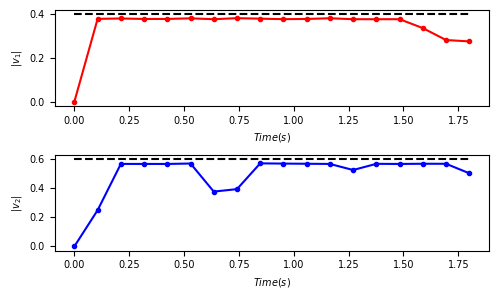

In [40]:
%matplotlib inline
t = np.linspace(0, N*dt, N)
plot(t, X1, X2, v1max=[Vmax[1]], v2max=[Vmax[2]])

## Section III-D: Minimization of Average Kinetic Energy Considering Moving Obstacles

In [41]:
import numpy as np
from cvxpy import *

L1 = 0.3 # meters
L2 = 0.3 # meters

dt = 0.1 # seconds
N  = 19  # 20 steps, from 0 to 9

x10 = np.array([ 0.3, 0.0])
x20 = np.array([ 0.6, 0.0])
x1f = np.array([0.0, 0.3])
x2f = np.array([0.3*np.sin(np.pi/4), 0.3+0.3*np.cos(np.pi/4)])

Vmax = np.array([0.0, 0.4, 0.6])

x1 = Variable((2,N+1)) # end point of link-1
x2 = Variable((2,N+1)) # end point of link-2

constraints  = [x1[:,0] == x10] # initial position
constraints += [x2[:,0] == x20] # initial position
constraints += [x1[:,N] == x1f] # terminal position
constraints += [x2[:,N] == x2f] # terminal position

# The big integer
R = 20

# Kinematic constraints
M   = 20 # increase this number to increase the accuracy of the results
b1  = Variable((M,N), boolean=True)
b2  = Variable((M,N), boolean=True)

for k in range (1,N):
    for m in range(0, M):
        # Circumscribed, eq. (6)
        constraints += [((x2[0,k]-x1[0,k])*np.sin(2*np.pi*(m+1)/M) + (x2[1,k]-x1[1,k])*np.cos(2*np.pi*(m+1)/M)) <= L1]
        constraints += [((x1[0,k])*np.sin(2*np.pi*(m+1)/M) + (x1[1,k])*np.cos(2*np.pi*(m+1)/M)) <= L2]
        # Inscribed, eq. (7)
        constraints += [((x2[0,k]-x1[0,k])*np.sin(2*np.pi*(m+1)/M) + (x2[1,k]-x1[1,k])*np.cos(2*np.pi*(m+1)/M)) >= L1*np.cos(np.pi/M)-b1[m,k]*R]
        constraints += [((x1[0,k])*np.sin(2*np.pi*(m+1)/M) + (x1[1,k])*np.cos(2*np.pi*(m+1)/M)) >= L2*np.cos(np.pi/M)-b2[m,k]*R]

    constraints += [sum(b1[:,k]) <= M-1, sum(b2[:,k]) <= M-1] # eq. (8)


# Using norm2 to constraint the velocity
M = 16

for k in range(0,N):
    for m in range(0,M):
        constraints += [((x1[0,k+1]-x1[0,k])*np.sin(2*np.pi*(m+1)/M) + (x1[1,k+1]-x1[1,k])*np.cos(2*np.pi*(m+1)/M)) <= Vmax[1]*dt]
        constraints += [((x2[0,k+1]-x2[0,k])*np.sin(2*np.pi*(m+1)/M) + (x2[1,k+1]-x2[1,k])*np.cos(2*np.pi*(m+1)/M)) <= Vmax[2]*dt]

# Collision/obstacles avoidance
# Particles in the links for collision avoidance
P = 12 # number of the particles for each link
#x1p = Variable((2*P,N+1)) # Particles in the first link
x2p = Variable((2*P,N+1))  # Particles in the second link
x1c = Variable((2,N+1)) # COM first link
x2c = Variable((2,N+1)) # COM second link

for k in range(0,N+1):
    for p in range(P):
        #constraints += [x1p[0+2*p:2+2*p, k]==x1[:, k]*p/(P-1)+np.zeros(2)]
        constraints += [x2p[0+2*p:2+2*p, k]==(x2[:, k]-x1[:, k])*p/(P-1)+x1[:, k]]

    constraints += [x1c[:, k]==(x1[:, k])*0.5] # COM1
    constraints += [x2c[:, k]==(x2[:, k]-x1[:, k])*0.5+x1[:, k]] # COM2

C = np.zeros((N+1,4))
for k in range(N+1):
    C[k,:] = np.array([[0.05+0.02105*k, 0.05+0.1+0.02105*k, 0.55-0.02105*k, 0.55+0.1-0.02105*k ]])

d1 = Variable((P, N+1), boolean=True)
d2 = Variable((P, N+1), boolean=True)
d3 = Variable((P, N+1), boolean=True)
d4 = Variable((P, N+1), boolean=True)

for k in range(0,N+1):
    for p in range(P):
        constraints += [x2p[0+2*p, k]  <=  C[k, 0] + R*d1[p,k],
                        -x2p[0+2*p, k] <= -C[k, 1] + R*d2[p,k],
                        x2p[1+2*p, k]  <=  C[k, 2] + R*d3[p,k],
                        -x2p[1+2*p, k] <= -C[k, 3] + R*d4[p,k]]
        constraints += [d1[p,k] + d2[p,k] + d3[p,k] + d4[p,k] <= 3]

# Minimum kinetic energy constraint
norm2v1 = Variable(N+1)
norm2v2 = Variable(N+1)
M = 10
for k in range(0,N):
    for m in range(0,M):
        constraints += [((x1c[0,k+1]-x1c[0,k])*np.sin(2*np.pi*(m+1)/M) + (x1c[1,k+1]-x1c[1,k])*np.cos(2*np.pi*(m+1)/M)) <= norm2v1[k]*dt]
        constraints += [((x2c[0,k+1]-x2c[0,k])*np.sin(2*np.pi*(m+1)/M) + (x2c[1,k+1]-x2c[1,k])*np.cos(2*np.pi*(m+1)/M)) <= norm2v2[k]*dt]

J = 1/N*(0.5*sum_squares(norm2v2) + 0.5*sum_squares(norm2v1))
prob = Problem(Minimize(J), constraints)

res = prob.solve(verbose=False, solver=SCIP, scip_params = {'parallel/mode' : 1, 'lp/threads' : 64, 'parallel/minnthreads' : 32})
#res = prob.solve(verbose=True, solver=MOSEK, mosek_params = {'MSK_IPAR_INTPNT_SOLVE_FORM':'MSK_SOLVE_DUAL' })
#res = prob.solve(solver=CPLEX, cplex_params={'threads':72}, verbose=True)
#res = prob.solve(solver=GUROBI, verbose=True)

# Trim the results
X1  = np.array(x1.value).transpose()
X2  = np.array(x2.value).transpose()
#X1P = x1p.value.transpose()
X2P = x2p.value.transpose()
COM1 = x1c.value.transpose()
COM2 = x2c.value.transpose()


N = len(X1)

In [42]:
%matplotlib notebook

ani = show_animation(np.array(X1), np.array(X2), L1, L2, x2p=X2P, CM=C, interval=200)
ani

<IPython.core.display.Javascript object>

In [43]:
ani.save("fig3.gif")

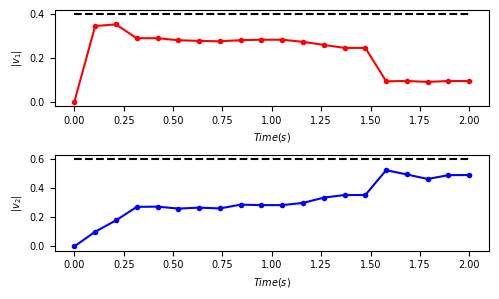

In [44]:
%matplotlib inline
t = np.linspace(0, N*dt, N)
plot(t, X1, X2, v1max=[Vmax[1]], v2max=[Vmax[2]])